# Biomedical Imaging 4C16/5C16 Project

## Tumor Segmentation & Classification

#### About the dataset

You have been given a dataset of ultrasound scans and segmentation maps associated with these ultrasound scans. These scans are to be used for training networks for ***breast cancer tumor segmentation and classification***.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *benign/*
        - *input.npy*
        - *target.npy*
    - *malignant/*
        - *input.npy*
        - *target.npy*
    - *normal/*
        - *input.npy*
        - *target.npy*

The *input.npy* and *output.npy* files are the input ultrasound scans and target segmentation maps for that tumor category (benign, malignant, normal).

- All input ultrasound scans are images of size 128x128x3. This means the height and width of these images are 128 and it is stored in RGB space. The pixels range from 0-1.
- All segmentation maps are images of size 128x128x1. This is an image where a value of 1 means that a tumor is detected at that location, and 0 means there is no tumor present.

The code block below displays examples of ultrasound scans and tumor segmentation maps for these image pairs.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:

# Function to save a model
def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print("Saved model to model.json and weights to model.h5")



In [4]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/medicalimaging-dataset.zip https://tcddeeplearning.blob.core.windows.net/deeplearning202324/medicalimaging-dataset.zip

!mkdir -p /home/tcd/data/medicalimaging/
!unzip -o /home/tcd/data/medicalimaging-dataset.zip -d /home/tcd/data/medicalimaging/

# Dataset is located in /home/tcd/data/medicalimaging/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.1M  100 16.1M    0     0  27.0M      0 --:--:-- --:--:-- --:--:-- 26.9M
Archive:  /home/tcd/data/medicalimaging-dataset.zip
  inflating: /home/tcd/data/medicalimaging/dataset/normal/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/normal/target.npy  


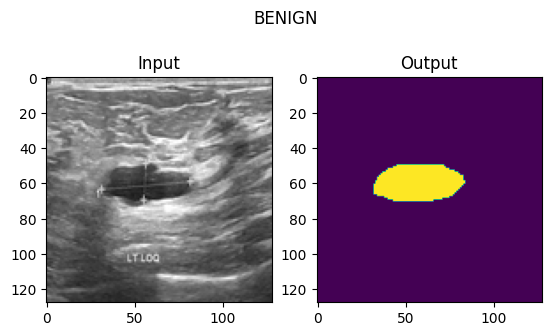

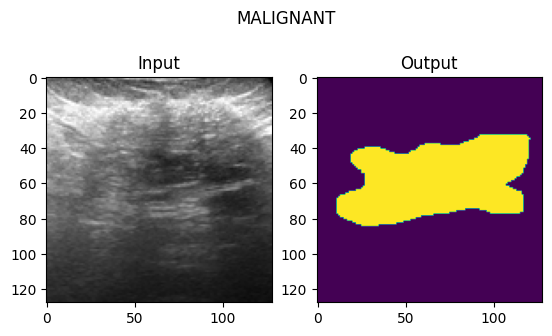

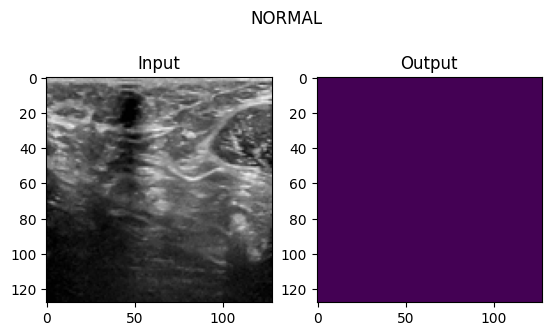

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

for _type in ['benign', 'malignant', 'normal']:
    X = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/input.npy')
    y = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/target.npy')
    randomExample = random.randint(0, X.shape[0] - 1)
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(X[randomExample])
    axs[0].title.set_text('Input')
    axs[1].imshow(y[randomExample])
    axs[1].title.set_text('Output')
    fig.suptitle(_type.upper())
    plt.subplots_adjust(top=1.1)
    plt.show()

### The problem

You are required to train two separate neural networks for the purposes of:

1. **Classification Task**: Predicting whether an ultrasound is a) benign tumor,  b) contains a malignant tumor or c) normal (no-tumor).
    - Input are ultra sound scans (data from benign/malignant/normal), the output is a vector of the 3 probabilities for the classes (benign/malignant/normal) in that order (eg. [0.01, 0.99, 0] means the outcome is more likely to be malignant).
2. **Segmentation Task**: Predicting the segmentation map for a tumor of an input MRI scan if a tumor exists
    - Input are ultra sound scans (data from benign/malignant/normal), output is an image with the same height and width as the input image, but with only one channel and a value of 1 over the location where a tumor is present.

---

*IMPORTANT*

For Task 1, your model should be created with the name: 'classification_model',
the model size should be under 5M

For Task 2, your model should be created with the name: 'segmentation_model',
the model size should be under 3M.

In [ ]:
# Hints:
#
# Load data into appropriate input/output formats.
# For example, for problem 1:
#   * inputs should be a collection of images of size [n_samples x height x width x 3],
#   * outputs should be of size [n_samples x height x width x 1].
#
# Load images using the `np.load` function. You can combine tensors using `np.concat`
# to form a single input or output dataset tensor. Look at previous labs for inspiration
# on what datasets look like.
#
# The amount of training data is very low, so usage of data
# augmentation techniques is strongly advised.(eg. see tf.keras.layers.RandomRotation)
#
# Classification Task hint: you may also think of using pre-trained networks
# with fine-tuning.
# Keep the model size under the restriction of 5Million parameters, you should
# be able to hit the target at much less model size. (Lower the better:))
#
# Segmentation Task hint: You might want to use transpose convolution layers to go up in tensor size.
# Popular segmentation architectures include U-Net (with skip-connections) or DnCNN.
# Keep the model size under the restriction of 3 Million parameters, you should
# be able to hit the target at very much lower model size. (Lower the better:))

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
import scipy.ndimage as sp_imaging
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow import keras
from matplotlib.ticker import MaxNLocator


# Function for loading and preparing the dataset
def prepare_data(dataset_path, label_type):
    data_inputs = np.load(f"{dataset_path}/{label_type}/input.npy")
    label_indices = np.full(data_inputs.shape[0], get_label_index(label_type))
    return data_inputs, label_indices

# Mapping label types to indices
def get_label_index(label_type):
    label_mapping = {'benign': 0, 'malignant': 1, 'normal': 2}
    return label_mapping[label_type]

# Augmentation function for the dataset
def dataset_augmentation(image_data, label_data):
    adjusted_contrast = tf.image.adjust_contrast(image_data, 1.2)
    blurred_data = sp_imaging.gaussian_filter(image_data, sigma=0.3)
    rotated_data = sp_imaging.rotate(image_data, angle=5, axes=(1, 2), reshape=False)

    combined_images = np.concatenate([image_data, adjusted_contrast, blurred_data, rotated_data])
    combined_labels = np.concatenate([label_data] * 4)
    return combined_images, combined_labels

# Paths and categories
data_path = "/home/tcd/data/medicalimaging/dataset"
data_categories = ['benign', 'malignant', 'normal']

# Loading and augmenting the data
all_datasets = [prepare_data(data_path, category) for category in data_categories]
all_images, all_labels = zip(*all_datasets)
augmented_images, augmented_labels = dataset_augmentation(
    np.vstack(all_images), np.concatenate(all_labels)
)

# Splitting the dataset
X_train, X_test, Y_train, Y_test = train_test_split(
    augmented_images, augmented_labels, test_size=0.3, random_state=33
)

# Building the model using MobileNetV2 with parameter constraints
def build_simplified_model():
    base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet', alpha=0.35)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')
    ])

    return model

model = build_simplified_model()

# Ensuring model's parameters are under 5 million
assert model.count_params() < 5e6, "Model's parameter count exceeds 5 million."

# Model compilation with sparse categorical crossentropy
model.compile(optimizer=optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for the training process
adjust_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=10)
save_best = callbacks.ModelCheckpoint('classification_model.h5', save_best_only=True)

model.summary()


# Define callback for dynamic plotting
class PlotLosses(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.x.append(self.i)
        self.i += 1

        clear_output(wait=True)
        plt.subplot(1, 2, 1)
        plt.plot(self.x, self.losses, label="training loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()



2019640/2019640 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.35_128 (Func  (None, 4, 4, 1280)        410208    
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                           

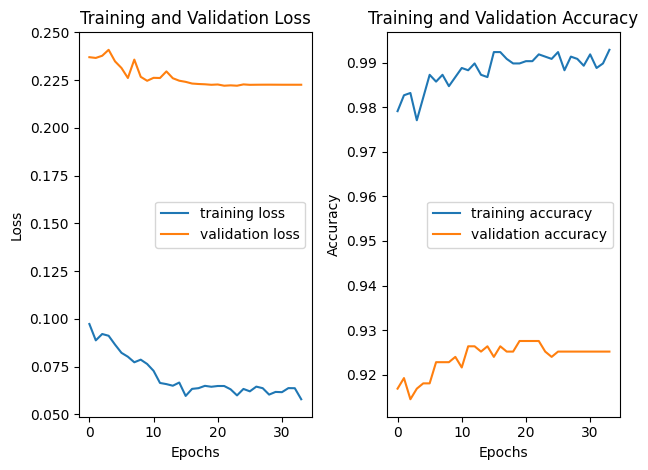

27/27 [==============================] - 0s 13ms/step - loss: 0.2226 - accuracy: 0.9252
Test Accuracy: 92.52%


In [9]:
# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLosses()

# Training the model
history = model.fit(X_train, Y_train, epochs=35, batch_size=32,
                    validation_data=(X_test, Y_test),
                    callbacks=[adjust_lr, stop_early, save_best,pltCallBack])
# Evaluate the model
evaluation_loss, evaluation_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {evaluation_accuracy*100:.2f}%")


In [ ]:
!pwd

/content/gdrive/MyDrive/4c16-labs/code/lab-06


In [10]:

classification_model = model
if (classification_model.count_params()  < 5000000) :
  save_model_to_disk(classification_model,"classification_model")
else:
  print("Your model is unecessarily complex, scale down!")





Saved model to model.json and weights to model.h5


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set your data path
Path = "/home/tcd/data/medicalimaging/dataset"

def load_data(data_path):
    X, y = [], []
    for _type in ['benign', 'malignant', 'normal']:
        X_type = np.load(f'{Path}/{_type}/input.npy')
        y_type = np.load(f'{Path}/{_type}/target.npy')  # Assumes y_type is a binary mask
        X.append(X_type)
        y.append(y_type)
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

def create_model(input_shape):
    inputs = Input(input_shape)

    x1, p1 = encoder_block(inputs, 32)
    x2, p2 = encoder_block(p1, 64)
    x3, p3 = encoder_block(p2, 128)
    b = conv_block(p3, 256)

    d1 = decoder_block(b, x3, 128)
    d2 = decoder_block(d1, x2, 64)
    d3 = decoder_block(d2, x1, 32)

    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d3)  # Output layer with kernel size (3, 3)

    return Model(inputs=[inputs], outputs=[outputs])

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

def augment_data(X_train, y_train, batch_size):
    data_gen_args = dict(rotation_range=360, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    seed = 1
    image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)
    return zip(image_generator, mask_generator)

# Load the data
X, y = load_data(Path)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and compile the model
model = create_model(X_train.shape[1:])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1_score])

# Setup callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('segmentation_model.h5', save_best_only=True)

# Data augmentation
train_generator = augment_data(X_train, y_train, batch_size=32)

model.summary()
# # Train the model
# history = model.fit(train_generator, steps_per_epoch=len(X_train) // 32, epochs=50,
#                     validation_data=(X_val, y_val), callbacks=[early_stopping,model_checkpoint])
# # Access the history to retrieve the final validation F1 score
# final_val_f1_score = history.history['val_f1_score'][-1]
# print(f"Final Validation F1 Score: {final_val_f1_score}")

# # Plot training history
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss Over Epochs')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy Over Epochs')
# plt.legend()
# plt.show()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['batch_normalization[0][0

Epoch 1/50
17/17 [==============================] - 4s 245ms/step - loss: 0.0640 - accuracy: 0.9712 - precision: 0.8525 - recall: 0.7830 - f1_score: 0.8137 - val_loss: 0.1632 - val_accuracy: 0.9572 - val_precision: 0.8253 - val_recall: 0.6453 - val_f1_score: 0.7153
Epoch 2/50
17/17 [==============================] - 4s 226ms/step - loss: 0.0633 - accuracy: 0.9713 - precision: 0.8656 - recall: 0.7838 - f1_score: 0.8211 - val_loss: 0.1716 - val_accuracy: 0.9563 - val_precision: 0.8662 - val_recall: 0.5873 - val_f1_score: 0.6922
Epoch 3/50
17/17 [==============================] - 5s 294ms/step - loss: 0.0660 - accuracy: 0.9703 - precision: 0.8662 - recall: 0.7830 - f1_score: 0.8193 - val_loss: 0.1713 - val_accuracy: 0.9583 - val_precision: 0.8604 - val_recall: 0.6092 - val_f1_score: 0.7094
Epoch 4/50
17/17 [==============================] - 6s 333ms/step - loss: 0.0597 - accuracy: 0.9735 - precision: 0.8808 - recall: 0.7882 - f1_score: 0.8295 - val_loss: 0.1546 - val_accuracy: 0.9577 - va

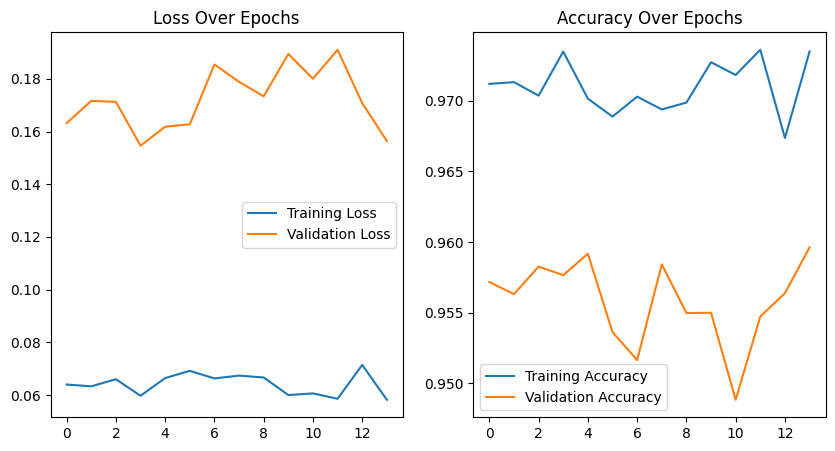

In [23]:
# Train the model
history = model.fit(train_generator, steps_per_epoch=len(X_train) // 32, epochs=50,
                    validation_data=(X_val, y_val), callbacks=[early_stopping,model_checkpoint])
# Access the history to retrieve the final validation F1 score
final_val_f1_score = history.history['val_f1_score'][-1]
print(f"Final Validation F1 Score: {final_val_f1_score}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [24]:
segmentation_model = model
if (segmentation_model.count_params()  < 3000000) :
  save_model_to_disk(segmentation_model, "segmentation_model")
else:
  print("Your model is unecessarily complex, scale down!")

Saved model to model.json and weights to model.h5
